### What:

Trying to get node classification with deepwalk+Label Propagation to work

### TODO:

- improve documentation/comments
- add train and test split to actually test performance for classiying
    - follow the authors code for the split. See main.py in the 'classifier' folder
        - same splits and hyperparameters
    - add code for LabelPropagation() to perform the task
- compare Perozzis embeddings with karateclub
    - make their shapes compatible

In [1]:
import numpy as np
import networkx as nx
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import embed_utils
from sklearn.model_selection import train_test_split
from copy import deepcopy
from collections import Counter
from matplotlib import pyplot as plt
from karateclub.dataset import GraphReader

In [6]:
def show_graph(G):
    # G = nx.Graph()
    # G.add_edge(1,2)
    # G.add_edge(2,3)
    # for v in G.nodes():
    #     G.node[v]['state']='X'
    # G.node[1]['state']='Y'
    # G.node[2]['state']='Y'

    # for n in G.edges_iter():
    #     G.edge[n[0]][n[1]]['state']='X'
    # G.edge[2][3]['state']='Y'

    node_labels = nx.get_node_attributes(G,embed_utils.CLASS_NAME)
    node_attr = nx.get_node_attributes(G,embed_utils.SENSATTR)

    color_map = []
    for node in G:
        if node_attr[node] == 0:
            color_map.append('blue')
        else: 
            color_map.append('green')   

    # pos = nx.spring_layout(G)

    # nx.draw(G, pos)
    nx.draw(G, node_color=color_map, labels = node_labels)
    # nx.draw_networkx_labels(G, pos, labels = node_labels)
    # edge_labels = nx.get_edge_attributes(G,'state')
    # nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
    # plt.savefig('this.png')
    plt.show()
    return

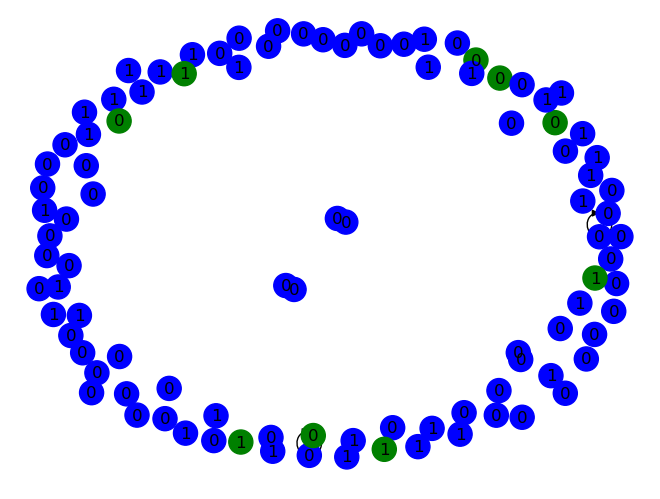

Graph info
Number of nodes: 98
Number of edges: 8
Length label dict: 98
Length attri dict: 98
Label dict: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 1, 18: 0, 19: 1, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 1, 35: 0, 36: 1, 37: 0, 38: 1, 39: 0, 40: 1, 41: 0, 42: 1, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 1, 53: 1, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 1, 61: 0, 62: 0, 63: 0, 64: 0, 65: 1, 66: 0, 67: 1, 68: 1, 69: 0, 70: 1, 71: 1, 72: 0, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 1, 82: 0, 83: 1, 84: 1, 85: 0, 86: 1, 87: 1, 88: 0, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 1, 97: 0}
Attri dict: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 1.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0

46.93877551020408

In [8]:
def get_metrics(classifier, test_nodes, embeddings, label_dict):

    test_node_embeddings = [emb for i, emb in enumerate(embeddings) if i in test_nodes]
    test_node_labels = [label_dict[node] for node in test_nodes]
    pred = classifier.predict(test_node_embeddings)
    accuracy = sum(test_node_labels == pred) / len(test_node_labels)
    
    return accuracy


def check_classification_params(nodes, labels, embeddings):
    assert nodes == list(range(len(nodes)))
    assert len(labels) == len(nodes) == len(embeddings), f"{len(labels)}, {len(nodes)}, {len(embeddings)}"


def make_classification_model(nodes, labels, embeddings):
    """
    Makes the classification model
    :param nodes: should be the nodes as list of consecutive integers
    :param labels: should be a list of labels where a value of -1
        indicates a missing label
    :param embeddings: is the embeddings of all nodes obtained using a
        (modified) random walk

    :returns: a model with a predict() function that predicts the label
        from embeddings
    """
    check_classification_params(nodes, labels, embeddings)

    g = np.mean(pairwise_distances(embeddings))
    clf = LabelPropagation(gamma = g).fit(embeddings, labels)

    return clf


def run_classification(dataset, method):

    # get graph from data
    graph = embed_utils.data2graph(dataset)

    show_graph(graph)

    print("Graph info")
    print(f"Number of nodes: {len(graph.nodes())}")
    print(f"Number of edges: {len(graph.edges())}")
    print(f"Length label dict: {len(nx.get_node_attributes(graph, embed_utils.CLASS_NAME))}")
    print(f"Length attri dict: {len(nx.get_node_attributes(graph, embed_utils.SENSATTR))}")
    print("Label dict:", nx.get_node_attributes(graph, embed_utils.CLASS_NAME))
    print("Attri dict:", nx.get_node_attributes(graph, embed_utils.SENSATTR))

    # Get labels and attributes of test nodes to other classes
    label_dict = deepcopy(nx.get_node_attributes(graph, embed_utils.CLASS_NAME))
    attr_dict = deepcopy(nx.get_node_attributes(graph, embed_utils.SENSATTR))

    has_attr = True
    if label_dict == {}:
        label_dict = attr_dict
        has_attr = False

    # get embedding from graph
    embeddings = embed_utils.graph2embed(
                                        graph, 
                                        "crosswalk", 
                                        method
                                        )
    
    # Split in to equal sized train and test nodes
    nodes = list(graph.nodes())
    shuffled_nodes = list(graph.nodes())
    np.random.shuffle(shuffled_nodes)
    split_idx = len(shuffled_nodes) // 2
    train_nodes, test_nodes = shuffled_nodes[:split_idx], shuffled_nodes[split_idx:]

    # Get semi-supervised labels
    semi_supervised_y = [label_dict[node] if node in train_nodes else -1 for node in nodes]

    # Train the classifier
    clf = make_classification_model(nodes, semi_supervised_y, embeddings)

    # Get test node embeddings, labels and find accuracy on test nodes
    if has_attr: 
        c0_nodes = [node for node in test_nodes if attr_dict[node] == 0]
        acc_c0 = get_metrics(clf, c0_nodes, embeddings, label_dict) * 100

        c1_nodes = [node for node in test_nodes if attr_dict[node] == 1]
        acc_c1 = get_metrics(clf, c1_nodes, embeddings, label_dict) * 100

    accuracy = get_metrics(clf, test_nodes, embeddings, label_dict) * 100
    
    if has_attr:
        print(f"Accuracy c0: {acc_c0}")
        print(f"Accuracy c1: {acc_c1}")
        print(f"Disparity: {np.var([acc_c0, acc_c1])}") 
        print()

    print(f"Total accuracy: {accuracy}")
    print()
    print(f"Counter training lables: {Counter([label_dict[node] for node in train_nodes]).most_common(3)}")
    print(f"Counter real lables: {Counter([label_dict[node] for node in test_nodes]).most_common(3)}")
    print(
        f"Counter prediction: {Counter(clf.predict([emb for i, emb in enumerate(embeddings) if i in test_nodes])).most_common(3)}"
        )
    print()

    return accuracy

n = 1
accs = []
for i in range(n):
    acc = run_classification(dataset="karateclub", method="node2vec")
    accs.append(acc)

np.mean(accs)